In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Flatten, concatenate, Input

def inception_module(inputs, conv1x1_out, conv3x3_reduce, conv3x3_out, conv5x5_reduce, conv5x5_out, pool_proj):
    # 1x1 convolution branch
    conv1x1 = Conv2D(conv1x1_out, (1, 1), padding='same', activation='relu')(inputs)
    
    # 3x3 convolution branch
    conv3x3_reduce = Conv2D(conv3x3_reduce, (1, 1), padding='same', activation='relu')(inputs)
    conv3x3 = Conv2D(conv3x3_out, (3, 3), padding='same', activation='relu')(conv3x3_reduce)
    
    # 5x5 convolution branch
    conv5x5_reduce = Conv2D(conv5x5_reduce, (1, 1), padding='same', activation='relu')(inputs)
    conv5x5 = Conv2D(conv5x5_out, (5, 5), padding='same', activation='relu')(conv5x5_reduce)
    
    # Max pooling branch
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    pool_proj = Conv2D(pool_proj, (1, 1), padding='same', activation='relu')(pool)
    
    # Concatenate the outputs of all branches
    output = concatenate([conv1x1, conv3x3, conv5x5, pool_proj], axis=-1)
    
    return output

def inception_net(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Initial convolution layers
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Inception modules
    x = inception_module(x, 16, 16, 32, 8, 16, 16)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    x = inception_module(x, 32, 16, 32, 8, 16, 16)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    x = inception_module(x, 32, 16, 32, 8, 16, 16)
    
    # Global average pooling
    x = AveragePooling2D((7, 7), strides=(1, 1), padding='valid')(x)
    
    # Fully connected layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

# Instantiate the model
input_shape = (224, 224, 1)
num_classes = 4 
model = inception_net(input_shape, num_classes)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 32)   0           ['conv2d[0][0]']                 
                                                                                              

In [2]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_ds = image_dataset_from_directory(
    directory='./hello1/Dataset',
    color_mode='grayscale',
    validation_split=0.3,
    subset='training',
    seed=123,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    interpolation='bilinear'
)

test_ds = image_dataset_from_directory(
    directory='./hello1/Dataset',
    color_mode='grayscale',
    validation_split=0.3,
    subset='validation',
    seed=123,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    interpolation='bilinear'
)

train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 11519 files belonging to 4 classes.
Using 8064 files for training.
Found 11519 files belonging to 4 classes.
Using 3455 files for validation.


In [4]:
hist = model.fit(train_ds, epochs=50, validation_data=test_ds)

Epoch 1/50
252/252 [==============================] - 11s 20ms/step - loss: 1.3847 - accuracy: 0.2718 - val_loss: 1.3602 - val_accuracy: 0.3372
Epoch 2/50
252/252 [==============================] - 4s 16ms/step - loss: 1.1039 - accuracy: 0.4701 - val_loss: 0.7950 - val_accuracy: 0.5763
Epoch 3/50
252/252 [==============================] - 4s 16ms/step - loss: 0.8014 - accuracy: 0.6066 - val_loss: 0.7274 - val_accuracy: 0.6463
Epoch 4/50
252/252 [==============================] - 4s 16ms/step - loss: 0.7472 - accuracy: 0.6367 - val_loss: 0.7292 - val_accuracy: 0.6217
Epoch 5/50
252/252 [==============================] - 4s 16ms/step - loss: 0.7260 - accuracy: 0.6497 - val_loss: 0.6804 - val_accuracy: 0.6781
Epoch 6/50
252/252 [==============================] - 4s 16ms/step - loss: 0.7037 - accuracy: 0.6638 - val_loss: 0.6404 - val_accuracy: 0.6964
Epoch 7/50
252/252 [==============================] - 4s 16ms/step - loss: 0.6492 - accuracy: 0.6921 - val_loss: 0.5909 - val_accuracy: 0.721

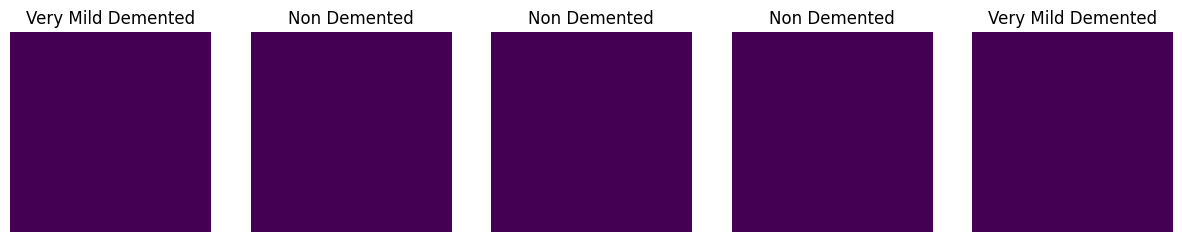

108/108 [==============================] - 1s 8ms/step


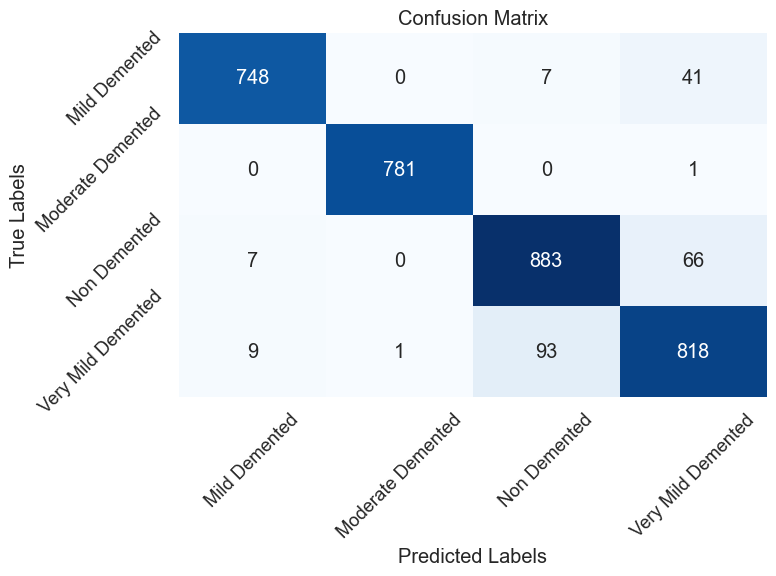

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Function to plot sample images from the dataset
def plot_sample_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.show()

# Plot sample images from the test dataset
plot_sample_images(test_ds, class_names=['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented'])

# Predict labels for the test dataset
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the test dataset
true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Compute classification report
class_report = classification_report(true_labels, predicted_labels)

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names, save_path=None):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)  # Save the plot as an image
    plt.show()

plot_confusion_matrix(conf_matrix, class_names=['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented'], save_path='confusion_matrixIN30.png')

# Save classification report to a text file
with open('classification_reportIN30.txt', 'w') as f:
    f.write(class_report)


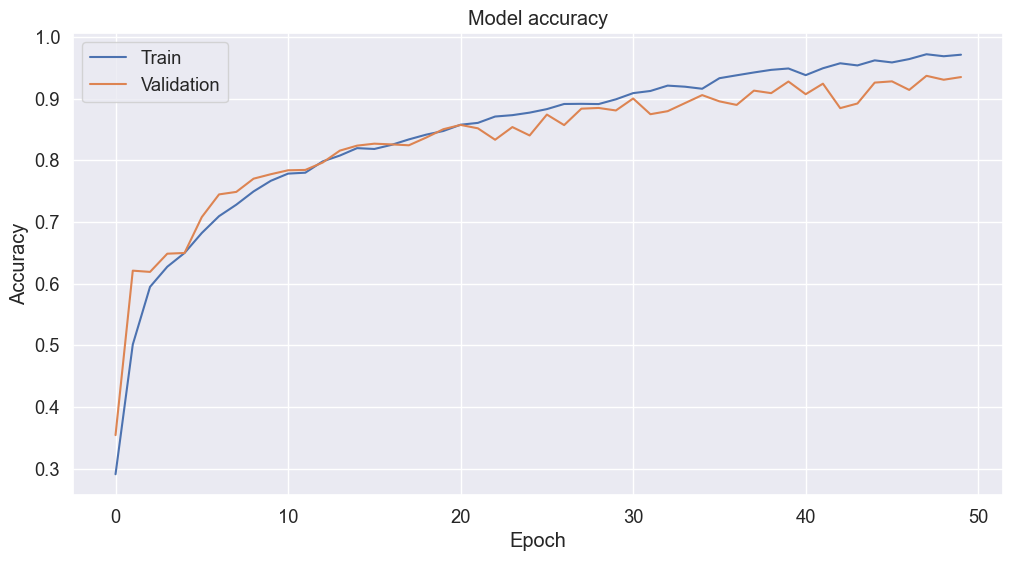

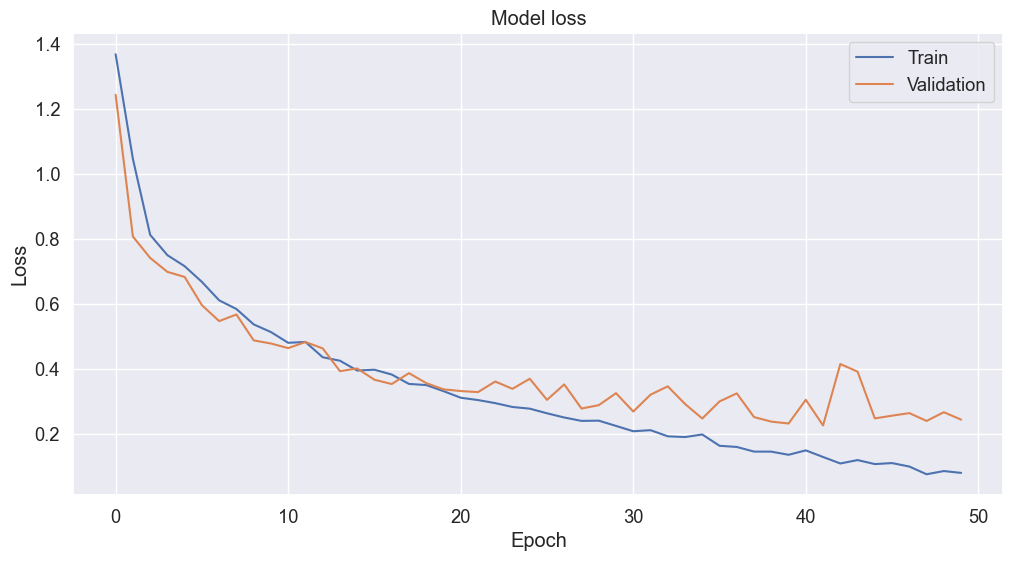

In [6]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)
    plt.savefig('AccuracyIN30.png')
    plt.show()

    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.grid(True)
    plt.savefig('LossIN30.png')
    plt.show()

plot_history(hist)


108/108 [==============================] - 1s 7ms/step


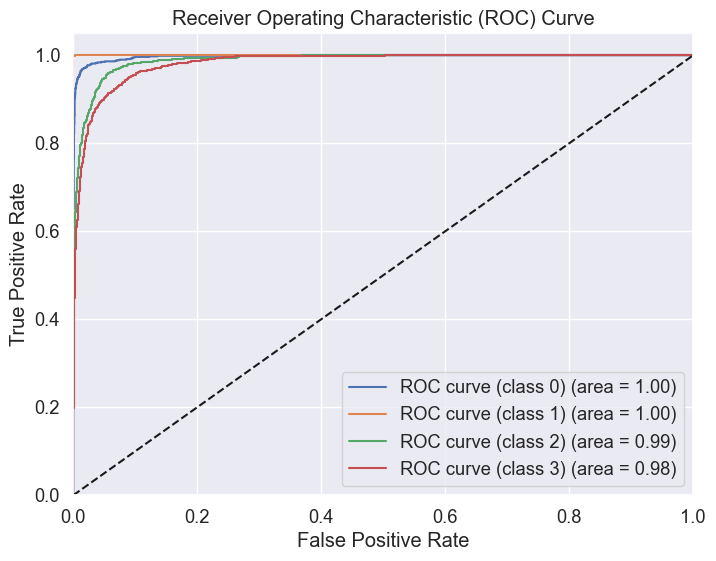

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Make predictions on the test data
y_pred_prob = model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (area = {:.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Save the plot as an image file
plt.savefig('ROCIN30.png')

# Show the plot
plt.show()
